# Experiments with Adams pretrained ResNet18 Models

-> Initialize models randomly to get a baseline performance on the test set

-> Compare against using a randomly selected pretained model to compare against

-> Loop over numbers of models used for clustering -> impact on final performance

-> Loop over numbers of layers initialised => impact on final performance

-> Optional: Use Fourier transform instead of Euclidian Distance for clustering

First we start by defining measurement function that takes an model as the input and then tests its learning performance on a subset of the superclasses from 10 to 20. These superclasses were not seen by the pretrained model

In [2]:
########################
### Params that select how may runs/sample etc

num_models_per_experiment = 5
num_subsets_to_test = 10


#########################

possible_tuples = []
for i in range(10,20):
    for j in range(i+1,20):
        possible_tuples.append((i,j))

# sample 10 tuples from the list of possible tuples
import random
# fix a seed
random.seed(1234)
sample_tuples = random.sample(possible_tuples,num_subsets_to_test)
# sort the tuples
sample_tuples.sort()
print(sample_tuples)


[(10, 11), (10, 13), (10, 16), (10, 17), (10, 18), (11, 18), (12, 18), (13, 18), (15, 18), (16, 19)]


In [3]:
import infrastructure as inf
import numpy as np
import torch.nn as nn

import torch 
torch.manual_seed(42)

from torchvision.models import resnet18

device = inf.device

epochs = 15
optimizer = 'SGD'
lr = 0.01
lr_reduce_patience = 5
normalization = True
model_params_dict = {}

data_loaders = [inf.get_loaders_cifar100_superclass_subsets_pytorch(i,j,128,6,normalization) for (i,j) in sample_tuples]

def eval_model(model, data_loaders, save_path, save_final_params=True):
    # returns mean min max of the model runs as format in tracked params
    model = model.to(device)
    tracked_params = []
    for loaders in data_loaders: 
        model, params = inf.train(model,loaders,lr=lr,epochs=epochs, tracking_freq=1, 
                           early_stopping_min_epochs=100,device=device,optimizer=optimizer
                           ,momentum=0.9,reduce_patience=lr_reduce_patience)
        tracked_params.append(params)
    # get mean min and max of the tracked params.
    p_mean, p_min, p_max = inf.list_tracked_params_to_avg(tracked_params,also_min_max=True)
    # save to disk
    if save_final_params:
        np.save(save_path + '_mean.npy',p_mean)
        np.save(save_path+ "_min.npy",p_min)
        np.save(save_path+ "_max.npy",p_max)
        
    return p_mean, p_min, p_max

def eval_models(models, data_loaders, save_path, save_final_params=True):
    # returns mean min max of the model runs as format in tracked params
    tracked_params = []
    for model in models:
        model = model.to(device)
        for loaders in data_loaders: 
            model, params = inf.train(model,loaders,lr=lr,epochs=epochs, tracking_freq=1, 
                            early_stopping_min_epochs=100,device=device,optimizer=optimizer
                            ,momentum=0.9,reduce_patience=lr_reduce_patience)
            tracked_params.append(params)
    # get mean min and max of the tracked params.
    p_mean, p_min, p_max = inf.list_tracked_params_to_avg(tracked_params,also_min_max=True)
    # save to disk
    if save_final_params:
        np.save(save_path + '_mean.npy',p_mean)
        np.save(save_path+ "_min.npy",p_min)
        np.save(save_path+ "_max.npy",p_max)
        
    return p_mean, p_min, p_max



Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


### Testing Random Model

100%|██████████| 25/25 [00:16<00:00,  1.49it/s]


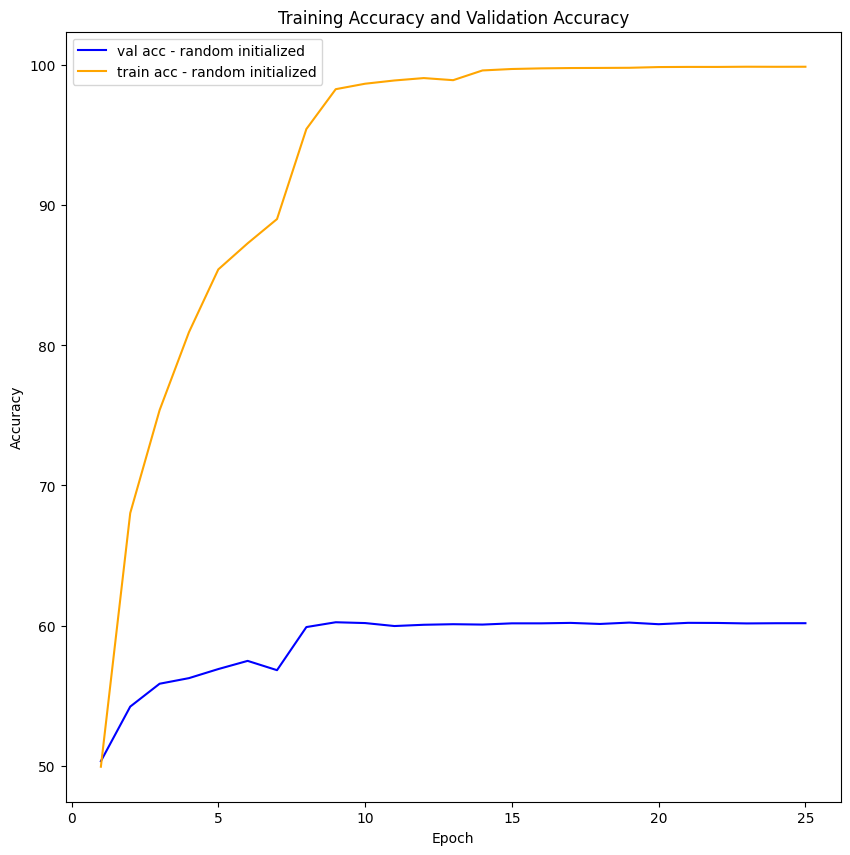

In [3]:
# Testing on two random initialized models
r_models = []
for i in range(num_models_per_experiment):
    model = resnet18(weights=None).to(device)
    model.fc = nn.Linear(512,10).to(device)
    r_models.append(model)
    
path = "./results_training_run2_Adams/experiment_results/r_model"
r_params = eval_models(r_models,data_loaders,path,True)



model_params_dict['random initialized'] = r_params

plot_path = "./results_training_run2_Adams/experiment_results/random_init"
inf.plot_trainings_mean_min_max(model_params_dict,display_train_acc=True,display_only_mean=True,save=True,save_path=plot_path,display=True)

### Testing Pretrained Model

[(0, 8), (0, 1), (4, 7), (4, 6), (1, 8)]


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


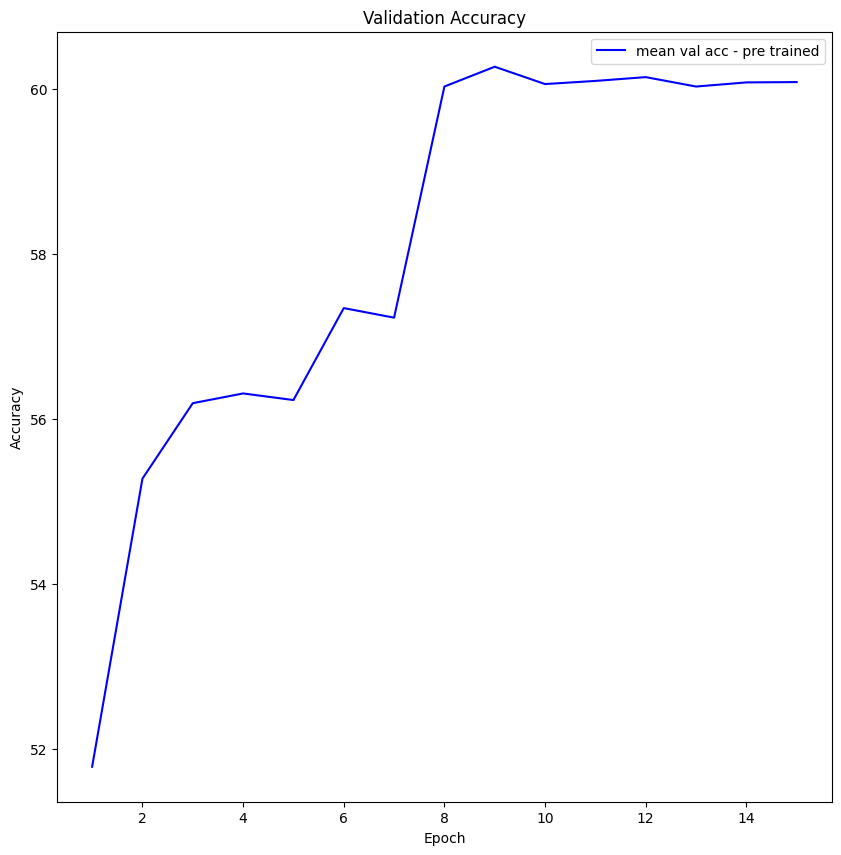

In [6]:
# load weights from disk: 

possible_tuples_pretrained = []
for i in range(10):
    for j in range(i+1,10):
        possible_tuples_pretrained.append((i,j))
        
        
tuples_to_load = random.sample(possible_tuples_pretrained,num_models_per_experiment)
print(tuples_to_load)

pre_trained_models_subset = []

for (i,j) in tuples_to_load:
    model = resnet18(weights=None).to(device)
    model.fc = nn.Linear(512,10).to(device)
    model.load_state_dict(torch.load(f"./results_training_run2_Adams/models_sgd/model_{i}_{j}.pt"))
    #model.fc = nn.Linear(512,10).to(device)
    
    pre_trained_models_subset.append(model)


path = "./results_training_run2_Adams/experiment_results/pre_trained_model"
pre_t_params = eval_models(pre_trained_models_subset,data_loaders,path,True)

model_params_dict['pre trained'] = pre_t_params

plot_path = "./results_training_run2_Adams/experiment_results/random_init_and_pre_trained"
inf.plot_trainings_mean_min_max(model_params_dict,display_train_acc=False,display_only_mean=True,save=True,save_path=plot_path,display=True)

## Testing initialization with Gabor Filters

In [13]:
def generate_gabor_filter(size, sigma, theta, Lambda, psi, gamma):
    """
    Generates a Gabor filter with given parameters.
    :param size: Size of the filter (size x size).
    :param sigma: Standard deviation of the Gaussian envelope.
    :param theta: Orientation of the Gabor filter.
    :param Lambda: Wavelength of the sinusoidal factor.
    :param psi: Phase offset.
    :param gamma: Spatial aspect ratio.
    :return: Gabor filter as a 2D array.
    """
    sigma_x = sigma
    sigma_y = sigma / gamma

    # Prepare grid in x and y
    x = np.linspace(-size // 2, size // 2, size)
    y = np.linspace(-size // 2, size // 2, size)
    x, y = np.meshgrid(x, y)

    # Rotation
    x_theta = x * np.cos(theta) + y * np.sin(theta)
    y_theta = -x * np.sin(theta) + y * np.cos(theta)

    gb = np.exp(-.5 * (x_theta ** 2 / sigma_x ** 2 + y_theta ** 2 / sigma_y ** 2)) * np.cos(2 * np.pi / Lambda * x_theta + psi)
    return gb

def initialize_model_gabor():
    
    model = resnet18(weights=None).to(device)
    model.fc = nn.Linear(512,10).to(device)

    for i in range(model.conv1.out_channels):  # Output channels of conv1
        np.random.seed(i)   #generate the same filters for each model but random inside of a model
        sigma = np.random.uniform(1.5, 2.5)  # Random sigma (Standard deviation of the Gaussian envelope)
        theta = np.random.uniform(0, np.pi)  # Random theta (Orientation of the Gabor filter)
        Lambda = np.random.uniform(2, 13)  # Random Lambda (wavelength)
        psi = np.random.uniform(0, 2*np.pi)   # Random psi (phase offset)
        gamma = np.random.uniform(0.9, 1.1)  # Random gamma (aspect ratio)
        for j in range(model.conv1.in_channels):  # Input channels of conv1
            gabor_filter = generate_gabor_filter(7, sigma, theta, Lambda, psi, gamma)
            model.conv1.weight.data[i, j, :, :] = torch.from_numpy(gabor_filter)

    return model

100%|██████████| 15/15 [00:09<00:00,  1.52it/s]


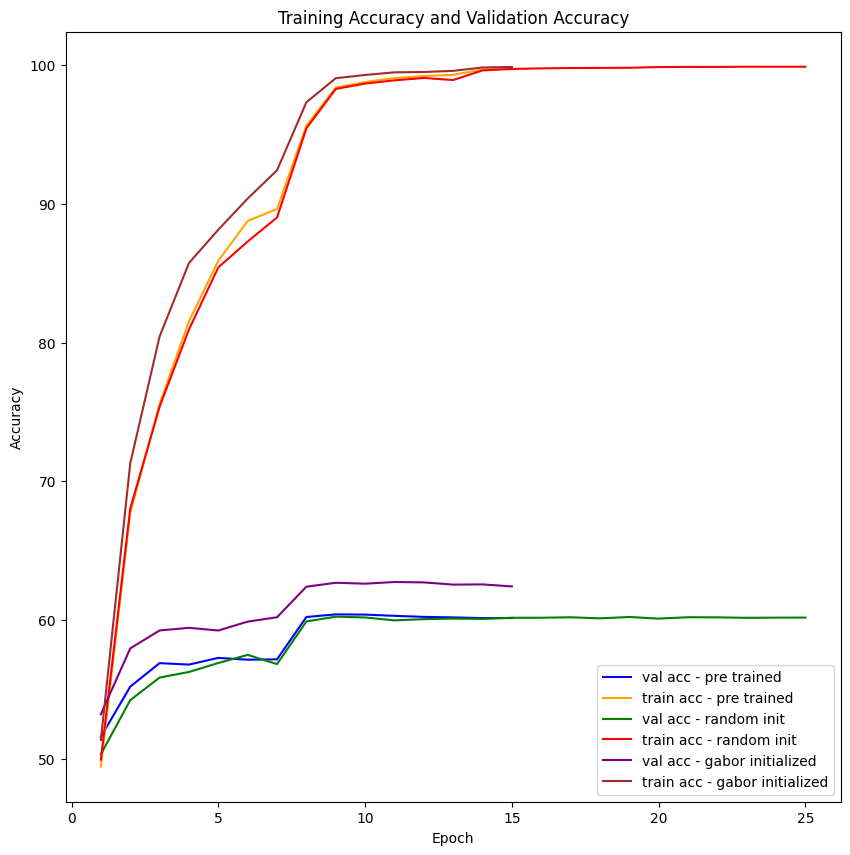

In [14]:
# Testing on two random initialized models
gabor_models = []
for i in range(num_models_per_experiment):
    model = initialize_model_gabor().to(device)
    gabor_models.append(model)
    
path = "./results_training_run2_Adams/experiment_results/gabor_model"
gabor_params = eval_models(gabor_models,data_loaders,path,True)



model_params_dict['gabor initialized'] = gabor_params

plot_path = "./results_training_run2_Adams/experiment_results/gabor_init"
inf.plot_trainings_mean_min_max(model_params_dict,display_train_acc=True,display_only_mean=True,save=True,save_path=plot_path,display=True)

# Fine grained Filter Clustering

In this approach a 3d filter is separated into the singel 2d filters. These 2d filters are then clustered using KMeans for every Layer separately. 

In [7]:
# first load all the models to memory that were pretrained

from sklearn.cluster import KMeans
pre_trained_models = []

for i in range(10):
    for j in range(i+1,10):
        # first check if this file exists: 
        try:
            model = resnet18(weights=None).to(device)
            model.fc = nn.Linear(512,10).to(device)
            model.load_state_dict(torch.load(f"./results_training_run2_Adams/models_sgd/model_{i}_{j}.pt"))
            pre_trained_models.append(model)
        except:
            continue
# shuffle the models 
np.random.shuffle(pre_trained_models)

print("Loaded",len(pre_trained_models),"pre trained models")

def models_to_filter_per_layer(models):
    print("Using",len(models),"models to create filters")
    filters_per_layer = {}
    
    filters_per_layer["0"] = []
    for model in models:
        filters_per_layer["0"].append(model.conv1.weight.data.cpu().numpy())
    
    filters_per_layer["1"] = []
    for model in models:
        filters_per_layer["1"].append(model.layer1[0].conv1.weight.data.cpu().numpy())
    
    filters_per_layer["2"] = []
    for model in models:
        filters_per_layer["2"].append(model.layer1[0].conv2.weight.data.cpu().numpy())

    filters_per_layer["3"] = []
    for model in models:
        filters_per_layer["3"].append(model.layer1[1].conv1.weight.data.cpu().numpy())
    
    filters_per_layer["4"] = []
    for model in models:
        filters_per_layer["4"].append(model.layer1[1].conv2.weight.data.cpu().numpy())

    filters_per_layer["5"] = []
    for model in models:
        filters_per_layer["5"].append(model.layer2[0].conv1.weight.data.cpu().numpy())

    filters_per_layer["6"] = []
    for model in models:
        filters_per_layer["6"].append(model.layer2[0].conv2.weight.data.cpu().numpy())

    filters_per_layer["7"] = []
    for model in models:
        filters_per_layer["7"].append(model.layer2[1].conv1.weight.data.cpu().numpy())

    filters_per_layer["8"] = []
    for model in models:
        filters_per_layer["8"].append(model.layer2[1].conv2.weight.data.cpu().numpy())

    filters_per_layer["9"] = []
    for model in models:
        filters_per_layer["9"].append(model.layer3[0].conv1.weight.data.cpu().numpy())

    filters_per_layer["10"] = []
    for model in models:
        filters_per_layer["10"].append(model.layer3[0].conv2.weight.data.cpu().numpy())

    filters_per_layer["11"] = []
    for model in models:
        filters_per_layer["11"].append(model.layer3[1].conv1.weight.data.cpu().numpy())

    filters_per_layer["12"] = []
    for model in models:
        filters_per_layer["12"].append(model.layer3[1].conv2.weight.data.cpu().numpy())

    filters_per_layer["13"] = []
    for model in models:
        filters_per_layer["13"].append(model.layer4[0].conv1.weight.data.cpu().numpy())

    filters_per_layer["14"] = []
    for model in models:
        filters_per_layer["14"].append(model.layer4[0].conv2.weight.data.cpu().numpy())

    filters_per_layer["15"] = []
    for model in models:
        filters_per_layer["15"].append(model.layer4[1].conv1.weight.data.cpu().numpy())

    filters_per_layer["16"] = []
    for model in models:
        filters_per_layer["16"].append(model.layer4[1].conv2.weight.data.cpu().numpy())

    for key in filters_per_layer.keys():
        filters_per_layer[key] = np.array(filters_per_layer[key])

    return filters_per_layer


def clustering_for_single_layer(filters_per_layer,layer_key, num_clusters):
    filters_per_layer[layer_key] = np.array(filters_per_layer[layer_key])
    # reshape every single filter to a 1d array
    #print(filters_per_layer[layer_key].shape)
    filters_per_layer[layer_key] = filters_per_layer[layer_key].reshape(-1, *filters_per_layer[layer_key].shape[3:])
    filters_per_layer[layer_key] = filters_per_layer[layer_key].reshape(filters_per_layer[layer_key].shape[0],-1)
    #print(filters_per_layer[layer_key].shape)
    # now it has the form #filters x #elements in filter (where 1 filter is one 2d array, stored as 1d)
    kmeans_filters = KMeans(n_clusters=num_clusters, n_init='auto',)
    cluster_labels = kmeans_filters.fit_predict(filters_per_layer[layer_key])
    
    # cluster centers:
    cluster_centers = kmeans_filters.cluster_centers_
    return cluster_labels, cluster_centers

def clustering_single_kmeans(models,device, num_clusters=30, num_layers=17):
    # num layers need to be at least 1 and at most 17
    assert num_layers >= 1 and num_layers <= 17

    
    # get dict of filters for every layer
    filters_per_layer = models_to_filter_per_layer(models)
    keys = list(filters_per_layer.keys())

    new_filters_per_layer = {}

    for layer_key in keys:
        num_3d_filters = filters_per_layer[layer_key].shape[1]

        #print(layer_key)
        orig_shape = filters_per_layer[layer_key].shape
        labels, centers = clustering_for_single_layer(filters_per_layer,layer_key,num_clusters)
        # create a prob density vector of the labels
        pdf = np.zeros(num_clusters)
        for i in range(labels.shape[0]):
            pdf[labels[i]] += 1
        pdf = pdf/labels.shape[0]
        # construct the vector of # filters x centroids 
        new_filters = np.zeros(orig_shape[1:])
        #print("new filters",new_filters.shape)    

        for i in range(new_filters.shape[0]):
            for j in range(new_filters.shape[1]):
                # sample an index from this pdf, this is the index of the cluster that we will use
                sampled_index = np.random.choice(num_clusters, p=pdf)
                #print(sampled_index)
                new_filters[i][j] = centers[sampled_index].reshape((new_filters.shape[2],new_filters.shape[3]))

        new_filters_per_layer[layer_key] = new_filters

     
        
    model = resnet18(num_classes=10).to(device)
    
    # go over all layers and set the new filters
    model.conv1.weight.data = torch.tensor(new_filters_per_layer["0"], dtype=torch.float32).to(device)
    if num_layers == 1: return model
    model.layer1[0].conv1.weight.data = torch.tensor(new_filters_per_layer["1"], dtype=torch.float32).to(device)
    if num_layers == 2: return model
    model.layer1[0].conv2.weight.data = torch.tensor(new_filters_per_layer["2"], dtype=torch.float32).to(device)
    if num_layers == 3: return model
    model.layer1[1].conv1.weight.data = torch.tensor(new_filters_per_layer["3"], dtype=torch.float32).to(device)
    if num_layers == 4: return model
    model.layer1[1].conv2.weight.data = torch.tensor(new_filters_per_layer["4"], dtype=torch.float32).to(device)
    if num_layers == 5: return model
    model.layer2[0].conv1.weight.data = torch.tensor(new_filters_per_layer["5"], dtype=torch.float32).to(device)
    if num_layers == 6: return model
    model.layer2[0].conv2.weight.data = torch.tensor(new_filters_per_layer["6"], dtype=torch.float32).to(device)
    if num_layers == 7: return model
    model.layer2[1].conv1.weight.data = torch.tensor(new_filters_per_layer["7"], dtype=torch.float32).to(device)
    if num_layers == 8: return model
    model.layer2[1].conv2.weight.data = torch.tensor(new_filters_per_layer["8"], dtype=torch.float32).to(device)
    if num_layers == 9: return model
    model.layer3[0].conv1.weight.data = torch.tensor(new_filters_per_layer["9"], dtype=torch.float32).to(device)
    if num_layers == 10: return model
    model.layer3[0].conv2.weight.data = torch.tensor(new_filters_per_layer["10"], dtype=torch.float32).to(device)
    if num_layers == 11: return model
    model.layer3[1].conv1.weight.data = torch.tensor(new_filters_per_layer["11"], dtype=torch.float32).to(device)
    if num_layers == 12: return model
    model.layer3[1].conv2.weight.data = torch.tensor(new_filters_per_layer["12"], dtype=torch.float32).to(device)
    if num_layers == 13: return model
    model.layer4[0].conv1.weight.data = torch.tensor(new_filters_per_layer["13"], dtype=torch.float32).to(device)
    if num_layers == 14: return model
    model.layer4[0].conv2.weight.data = torch.tensor(new_filters_per_layer["14"], dtype=torch.float32).to(device)
    if num_layers == 15: return model
    model.layer4[1].conv1.weight.data = torch.tensor(new_filters_per_layer["15"], dtype=torch.float32).to(device)
    if num_layers == 16: return model
    model.layer4[1].conv2.weight.data = torch.tensor(new_filters_per_layer["16"], dtype=torch.float32).to(device)
    
    return model


Loaded 45 pre trained models


## Single Filter Kmeans Fourier Space Clustering



In [8]:
from sklearn.cluster import KMeans
def dft(weights):
    ffts = []
    for i in range(weights.shape[0]):
        ffts.append(np.fft.fft2(weights[i]))
    ffts = np.array(ffts)
    return np.real(ffts), np.imag(ffts)

def inverse_dft(cluster_results):
    weights = []
    for i in range(cluster_results.shape[0]):
        weights.append(np.fft.ifft2(cluster_results[i]))
    weights = np.array(weights)
    return np.real(weights), np.imag(weights)

# filters = filters_per_layer[layer_key]
def clustering_fourier_single_layer(filters, num_clusters):
    filters_reshaped = np.reshape(filters, (filters.shape[0]*filters.shape[1]*filters.shape[2],filters.shape[3],filters.shape[4]))
    dfts, _ = dft(filters_reshaped)
    dfts_reshaped = np.reshape(dfts,(dfts.shape[0],dfts.shape[1]*dfts.shape[2]))
    kmeans = KMeans(n_clusters = num_clusters, n_init='auto')
    cluster_labels = kmeans.fit_predict(dfts_reshaped)
    
    #final_weights, _ = inverse_dft(np.reshape(kmeans.cluster_centers_, (dfts.shape[0],dfts.shape[1],dfts.shape[2])))
    final_weights, _ = inverse_dft(np.reshape(kmeans.cluster_centers_, (kmeans.cluster_centers_.shape[0],dfts.shape[1],dfts.shape[2])))
    return cluster_labels, final_weights

def clustering_single_fourier(models,device, num_clusters=30, num_layers=17):
    # num layers need to be at least 1 and at most 17
    assert num_layers >= 1 and num_layers <= 17

    
    # get dict of filters for every layer
    filters_per_layer = models_to_filter_per_layer(models)
    keys = list(filters_per_layer.keys())

    new_filters_per_layer = {}

    
    for layer_key in keys:
        num_3d_filters = filters_per_layer[layer_key].shape[1]

        #print(layer_key)
        orig_shape = filters_per_layer[layer_key].shape
        
        labels, centers = clustering_fourier_single_layer(filters_per_layer[layer_key],num_clusters)
        
        #labels, centers = clustering_for_single_layer(filters_per_layer,layer_key,num_clusters)
        
        # create a prob density vector of the labels
        pdf = np.zeros(num_clusters)
        for i in range(labels.shape[0]):
            pdf[labels[i]] += 1
        pdf = pdf/labels.shape[0]
        # construct the vector of # filters x centroids 
        new_filters = np.zeros(orig_shape[1:])
        #print("new filters",new_filters.shape)    

        for i in range(new_filters.shape[0]):
            for j in range(new_filters.shape[1]):
                # sample an index from this pdf, this is the index of the cluster that we will use
                sampled_index = np.random.choice(num_clusters, p=pdf)
                #print(sampled_index)
                new_filters[i][j] = centers[sampled_index].reshape((new_filters.shape[2],new_filters.shape[3]))

        new_filters_per_layer[layer_key] = new_filters

     
        
    model = resnet18(num_classes=10).to(device)
    
    # go over all layers and set the new filters
    model.conv1.weight.data = torch.tensor(new_filters_per_layer["0"], dtype=torch.float32).to(device)
    if num_layers == 1: return model
    model.layer1[0].conv1.weight.data = torch.tensor(new_filters_per_layer["1"], dtype=torch.float32).to(device)
    if num_layers == 2: return model
    model.layer1[0].conv2.weight.data = torch.tensor(new_filters_per_layer["2"], dtype=torch.float32).to(device)
    if num_layers == 3: return model
    model.layer1[1].conv1.weight.data = torch.tensor(new_filters_per_layer["3"], dtype=torch.float32).to(device)
    if num_layers == 4: return model
    model.layer1[1].conv2.weight.data = torch.tensor(new_filters_per_layer["4"], dtype=torch.float32).to(device)
    if num_layers == 5: return model
    model.layer2[0].conv1.weight.data = torch.tensor(new_filters_per_layer["5"], dtype=torch.float32).to(device)
    if num_layers == 6: return model
    model.layer2[0].conv2.weight.data = torch.tensor(new_filters_per_layer["6"], dtype=torch.float32).to(device)
    if num_layers == 7: return model
    model.layer2[1].conv1.weight.data = torch.tensor(new_filters_per_layer["7"], dtype=torch.float32).to(device)
    if num_layers == 8: return model
    model.layer2[1].conv2.weight.data = torch.tensor(new_filters_per_layer["8"], dtype=torch.float32).to(device)
    if num_layers == 9: return model
    model.layer3[0].conv1.weight.data = torch.tensor(new_filters_per_layer["9"], dtype=torch.float32).to(device)
    if num_layers == 10: return model
    model.layer3[0].conv2.weight.data = torch.tensor(new_filters_per_layer["10"], dtype=torch.float32).to(device)
    if num_layers == 11: return model
    model.layer3[1].conv1.weight.data = torch.tensor(new_filters_per_layer["11"], dtype=torch.float32).to(device)
    if num_layers == 12: return model
    model.layer3[1].conv2.weight.data = torch.tensor(new_filters_per_layer["12"], dtype=torch.float32).to(device)
    if num_layers == 13: return model
    model.layer4[0].conv1.weight.data = torch.tensor(new_filters_per_layer["13"], dtype=torch.float32).to(device)
    if num_layers == 14: return model
    model.layer4[0].conv2.weight.data = torch.tensor(new_filters_per_layer["14"], dtype=torch.float32).to(device)
    if num_layers == 15: return model
    model.layer4[1].conv1.weight.data = torch.tensor(new_filters_per_layer["15"], dtype=torch.float32).to(device)
    if num_layers == 16: return model
    model.layer4[1].conv2.weight.data = torch.tensor(new_filters_per_layer["16"], dtype=torch.float32).to(device)
    
    return model

## Fine grained clustering of filters experiment - Number of pretrained models used for clustering

For this experiment the number of clusters is set 10 and the number of layers is set to all 17. 

Using 2 models to create filters
Using 2 models to create filters
Using 2 models to create filters
Using 2 models to create filters
Using 2 models to create filters
Using 2 models to create filters
Using 2 models to create filters
Using 2 models to create filters
Using 2 models to create filters
Using 2 models to create filters


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Using 4 models to create filters
Using 4 models to create filters
Using 4 models to create filters
Using 4 models to create filters
Using 4 models to create filters
Using 4 models to create filters
Using 4 models to create filters
Using 4 models to create filters
Using 4 models to create filters
Using 4 models to create filters


100%|██████████| 15/15 [00:07<00:00,  1.93it/s]


Using 6 models to create filters
Using 6 models to create filters
Using 6 models to create filters
Using 6 models to create filters
Using 6 models to create filters
Using 6 models to create filters
Using 6 models to create filters
Using 6 models to create filters
Using 6 models to create filters
Using 6 models to create filters


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


Using 20 models to create filters
Using 20 models to create filters
Using 20 models to create filters
Using 20 models to create filters
Using 20 models to create filters
Using 20 models to create filters
Using 20 models to create filters
Using 20 models to create filters
Using 20 models to create filters
Using 20 models to create filters


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


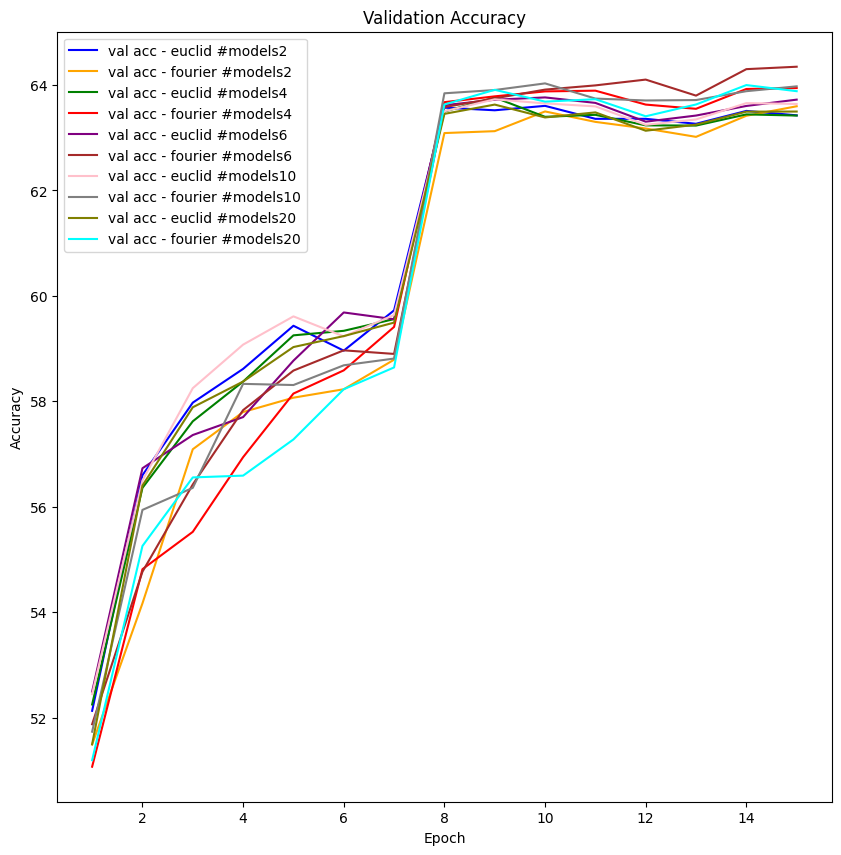

In [6]:
choices_num_models_used = [2,4,6,10,20]

num_models_dict = {}

for num_models_used in choices_num_models_used:
    #print("Using",num_models_used,"models for clustering")
    # create a subset of the pre trained models
    subset_models = pre_trained_models[:num_models_used]
    # create a model with the clustered filters
    
    clustered_models_euclid = [clustering_single_kmeans(subset_models,device, num_clusters=10, num_layers=17) for i in range(num_models_per_experiment)]
    clustered_models_fourier = [clustering_single_fourier(subset_models,device, num_clusters=10, num_layers=17) for i in range(num_models_per_experiment)]
    # evaluate the model
    path = f"./results_training_run2_Adams/experiment_results/euclid_model_num_models_{num_models_used}"
    euclid_params = eval_models(clustered_models_euclid,data_loaders,path,True)
    path = f"./results_training_run2_Adams/experiment_results/fourier_model_num_models_{num_models_used}"
    fourier_params = eval_models(clustered_models_fourier,data_loaders,path,True)
    
    model_params_dict[f'euclid #models{num_models_used}'] = euclid_params
    model_params_dict[f'fourier #models{num_models_used}'] = fourier_params
    
    num_models_dict[f'euclid #models{num_models_used}'] = euclid_params
    num_models_dict[f'fourier #models{num_models_used}'] = fourier_params

plot_path = "./results_training_run2_Adams/experiment_results/clustered_num_models"
# add r_results to the dict
#num_models_dict['random initialized'] = r_params
inf.plot_trainings_mean_min_max(num_models_dict,display_train_acc=False,display_only_mean=True,save=True,save_path=plot_path,display=True)

## Fine grained clustering of filters experiment - Number of clusters used to produce clustering on filters

For this experiment the model is initialized with all filter layers and using 10 pretrained models.

Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters
Using 10 models to create filters


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


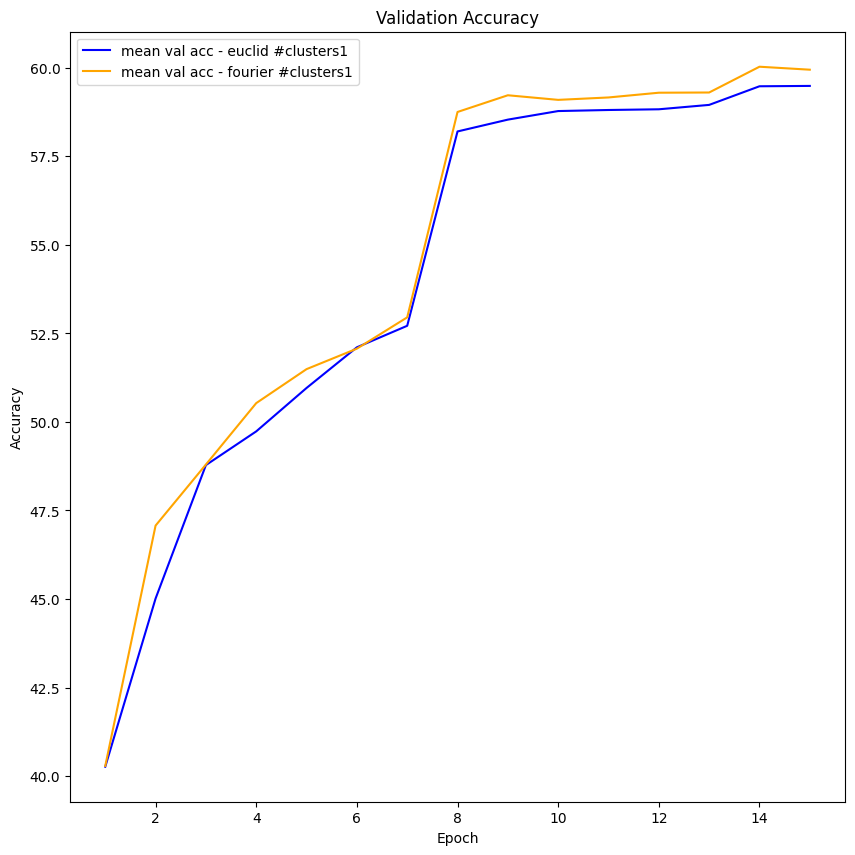

Using 10 models to create filters
Using 10 models to create filters


KeyboardInterrupt: 

In [9]:
choices_num_clusters = [1] #2,3,10,30,50] 

num_clusters_dict = {}

for num_clusters in choices_num_clusters:
    # create a subset of the pre trained models
    subset_models = pre_trained_models[:10]
    # create a model with the clustered filters
    
    euclid_models = [clustering_single_kmeans(subset_models,device, num_clusters=num_clusters, num_layers=17) for i in range(num_models_per_experiment)]
    fourier_models = [clustering_single_fourier(subset_models,device, num_clusters=num_clusters, num_layers=17) for i in range(num_models_per_experiment)]
    # evaluate the model
    path = f"./results_training_run2_Adams/experiment_results/euclid_model_num_clusters_{num_clusters}"
    euclid_params = eval_models(euclid_models,data_loaders,path,True)
    path = f"./results_training_run2_Adams/experiment_results/fourier_model_num_clusters_{num_clusters}"
    fourier_params = eval_models(fourier_models,data_loaders,path,True)
    
    
    model_params_dict[f'euclid #clusters{num_clusters}'] = euclid_params
    model_params_dict[f'fourier #clusters{num_clusters}'] = fourier_params
    
    num_clusters_dict[f'euclid #clusters{num_clusters}'] = euclid_params
    num_clusters_dict[f'fourier #clusters{num_clusters}'] = fourier_params

plot_path = "./results_training_run2_Adams/experiment_results/clustered_num_clusters"
# add r_results to the dict
#num_clusters_dict['random initialized'] = r_params
inf.plot_trainings_mean_min_max(num_clusters_dict,display_train_acc=False,display_only_mean=True,save=True,save_path=plot_path,display=True)





choices_num_layers = [1,2,6,10,17]

num_filters_dict = {}

for num_layers in choices_num_layers:
    # create a subset of the pre trained models
    subset_models = pre_trained_models[:10]
    # create a model with the clustered filters
    euclid_models = [clustering_single_kmeans(subset_models,device, num_clusters=10, num_layers=num_layers) for i in range(num_models_per_experiment)]
    fourier_models = [clustering_single_fourier(subset_models,device, num_clusters=10, num_layers=num_layers) for i in range(num_models_per_experiment)]
    # evaluate the model
    path = f"./results_training_run2_Adams/experiment_results/euclid_model_num_layers_{num_layers}"
    euclid_params = eval_models(euclid_models,data_loaders,path,True)
    path = f"./results_training_run2_Adams/experiment_results/fourier_model_num_layers_{num_layers}"
    fourier_params = eval_models(fourier_models,data_loaders,path,True)
    
    model_params_dict[f'euclid #layers{num_layers}'] = euclid_params
    model_params_dict[f'fourier #layers{num_layers}'] = fourier_params
    
    num_filters_dict[f'euclid #layers{num_layers}'] = euclid_params
    num_filters_dict[f'fourier #layers{num_layers}'] = fourier_params

plot_path = "./results_training_run2_Adams/experiment_results/clustered_num_layers"
# add r_results to the dict
#num_filters_dict['random initialized'] = r_params
inf.plot_trainings_mean_min_max(num_filters_dict,display_train_acc=False,display_only_mean=True,save=True,save_path=plot_path,display=True)

## Fine grained clustering of filters experiment - Number of filters initialized 

For this experiment the model is initialized using 10 pretrained models and using 10 clusters. (starting from the first layer to the end of the model)

In [9]:
"""
choices_num_layers = [1,2,6,10,17]

num_filters_dict = {}

for num_layers in choices_num_layers:
    # create a subset of the pre trained models
    subset_models = pre_trained_models[:10]
    # create a model with the clustered filters
    euclid_models = [clustering_single_kmeans(subset_models,device, num_clusters=10, num_layers=num_layers) for i in range(num_models_per_experiment)]
    fourier_models = [clustering_single_fourier(subset_models,device, num_clusters=10, num_layers=num_layers) for i in range(num_models_per_experiment)]
    # evaluate the model
    path = f"./results_training_run2_Adams/experiment_results/euclid_model_num_layers_{num_layers}"
    euclid_params = eval_models(euclid_models,data_loaders,path,True)
    path = f"./results_training_run2_Adams/experiment_results/fourier_model_num_layers_{num_layers}"
    fourier_params = eval_models(fourier_models,data_loaders,path,True)
    
    model_params_dict[f'euclid #layers{num_layers}'] = euclid_params
    model_params_dict[f'fourier #layers{num_layers}'] = fourier_params
    
    num_filters_dict[f'euclid #layers{num_layers}'] = euclid_params
    num_filters_dict[f'fourier #layers{num_layers}'] = fourier_params

plot_path = "./results_training_run2_Adams/experiment_results/clustered_num_layers"
# add r_results to the dict
#num_filters_dict['random initialized'] = r_params
inf.plot_trainings_mean_min_max(num_filters_dict,display_train_acc=False,display_only_mean=True,save=True,save_path=plot_path,display=True)
"""

'\nchoices_num_layers = [1,2,6,10,17]\n\nnum_filters_dict = {}\n\nfor num_layers in choices_num_layers:\n    # create a subset of the pre trained models\n    subset_models = pre_trained_models[:10]\n    # create a model with the clustered filters\n    euclid_models = [clustering_single_kmeans(subset_models,device, num_clusters=10, num_layers=num_layers) for i in range(num_models_per_experiment)]\n    fourier_models = [clustering_single_fourier(subset_models,device, num_clusters=10, num_layers=num_layers) for i in range(num_models_per_experiment)]\n    # evaluate the model\n    path = f"./results_training_run2_Adams/experiment_results/euclid_model_num_layers_{num_layers}"\n    euclid_params = eval_models(euclid_models,data_loaders,path,True)\n    path = f"./results_training_run2_Adams/experiment_results/fourier_model_num_layers_{num_layers}"\n    fourier_params = eval_models(fourier_models,data_loaders,path,True)\n    \n    model_params_dict[f\'euclid #layers{num_layers}\'] = euclid_par